In [2]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import CLIPImageProcessor, CLIPVisionModel
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from diffusers.models.attention_processor import Attention
import torchvision.transforms as T
import wandb
from PIL import Image
import os
from tqdm import tqdm

In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class EEGToCLIPProjector(nn.Module):
    def __init__(self, eeg_dim=1024, clip_dim=512):
        super().__init__()
        self.project = nn.Sequential(
            nn.Linear(eeg_dim, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Linear(1024, clip_dim),
        )

    def forward(self, x):
        x = self.project(x)
        return F.normalize(x, dim=-1)

In [5]:
model = EEGToCLIPProjector().to(device)
model.load_state_dict(torch.load("/kaggle/input/clipprojector/eeg_to_clip_projector_best (1).pth"))
model.eval()

EEGToCLIPProjector(
  (project): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=1024, out_features=512, bias=True)
  )
)

In [6]:
data = torch.load('/kaggle/input/sahajb/dataset/dataset/eeg_5_95_std.pth', weights_only=False)
for i in range(len(data['dataset'])):
    data['dataset'][i]['eeg']=data['dataset'][i]['eeg'].detach().cpu().numpy()
pdata=pd.DataFrame(data['dataset'])
pdata=pdata['eeg']

def normalize_channels(epoch, means=None, stddevs=None):
    """
    Args:
        epoch: np.ndarray or torch.Tensor, shape [128, T]
        means: torch.Tensor or np.ndarray, shape [128, 1]
        stddevs: torch.Tensor or np.ndarray, shape [128, 1]
    Returns:
        torch.Tensor: normalized epoch [128, T]
    """
    if not isinstance(epoch, torch.Tensor):
        epoch = torch.tensor(epoch.copy(), dtype=torch.float32)
    if means is None or stddevs is None:
        # Compute from this epoch if not provided
        means = epoch.mean(dim=1, keepdim=True)
        stddevs = epoch.std(dim=1, keepdim=True)
    else:
        if isinstance(means, np.ndarray):
            means = torch.tensor(means, dtype=epoch.dtype)
        if isinstance(stddevs, np.ndarray):
            stddevs = torch.tensor(stddevs, dtype=epoch.dtype)

    stddevs = stddevs.clone()
    stddevs[stddevs == 0] = 1e-6
    return (epoch - means) / stddevs

def pad_channels_to_128(epoch):
    num_channels = epoch.shape[0]
    if num_channels == 128:
        return epoch
    elif num_channels < 128:
        reps = 128 // num_channels + 1
        padded = np.tile(epoch, (reps, 1))[:128, :]
        return padded
    else:
        return epoch[:128, :]

pdata = pdata.apply(lambda x: pad_channels_to_128(x))

pdata= pdata.apply(lambda x: normalize_channels(x))

def tokenize_sample(eeg_sample, token_length=4):
    C, T = eeg_sample.shape

    pad_length = (token_length - (T % token_length)) % token_length
    if pad_length > 0:
        padded_data = np.pad(eeg_sample, ((0, 0), (0, pad_length)), mode='edge')
    else:
        padded_data = eeg_sample

    num_tokens = padded_data.shape[1] // token_length
    tokens = padded_data.reshape(128, num_tokens, token_length)  # (128, num_tokens, 4)
    tokens = np.transpose(tokens, (1, 0, 2))  # (num_tokens, 128, 4)

    return tokens

pdata = pd.DataFrame(pdata.apply(lambda x : tokenize_sample(x)))

projection = nn.Linear(128 * 4, 1024)

def embed(tokens):
    all_embeddings = []
    if isinstance(tokens, np.ndarray):
        tokens = torch.from_numpy(tokens).to(torch.float32)
    else:
        tokens = tokens.clone().detach().to(torch.float32)

    flattened = tokens.reshape(-1, 128 * 4)  # (num_tokens, 512)
    embeddings = projection(flattened)
    all_embeddings.append(embeddings)
    return all_embeddings[0]

pdata['embeddings'] = (pdata['eeg']).apply(lambda x : embed(x))
pdata['embeddingsavg']=np.zeros((len(pdata), 1024)).tolist()
for i in range(11965):      
    pdata.at[i, 'embeddingsavg']=pdata['embeddings'][i].detach().numpy().mean(axis=0)
pdatac=pd.DataFrame(pdata['embeddingsavg'])
temp=pd.DataFrame(data['dataset'])
pdatac['image']=temp['image']
pdatac['name']=''
ima=pd.DataFrame({'images': (data['images'])})
for i in range(11965):      
    pdatac.at[i, 'name']=ima['images'][pdatac['image'][i]]+'.JPEG'
pdatac.drop(pdatac[pdatac['name'] == 'n03452741_17620.JPEG'].index, inplace=True)

In [9]:
pdatac

,embeddingsavg,image,name
0,"[-0.0024521225, 0.0037646336, 0.008004111, 0.0...",0,n02951358_31190.JPEG
1,"[-0.001417937, 0.00023697224, 0.011594881, 0.0...",1,n03452741_16744.JPEG
2,"[-0.0017605729, 0.0038597607, 0.008485739, 0.0...",2,n04069434_10318.JPEG
3,"[-0.0012331329, 0.004560833, 0.007263576, 0.01...",3,n02951358_34807.JPEG
4,"[-0.0024281912, 0.0013135998, 0.008905679, 0.0...",4,n03452741_5499.JPEG
...,...,...,...
11960,"[-0.0021274663, 0.002444749, 0.010154843, 0.00...",1991,n02492035_4451.JPEG
11961,"[-0.0017951349, 0.0019760558, 0.010971916, 0.0...",1992,n07873807_8902.JPEG
11962,"[-0.00073791825, 0.005462189, 0.011812741, 0.0...",1993,n02607072_304.JPEG
11963,"[-0.00030425788, 0.005140023, 0.011646125, 0.0...",1994,n03297495_2959.JPEG


In [10]:
projected_embeddings = []

with torch.no_grad():
    for eeg in pdatac['embeddingsavg']:
        if eeg is not None:
            eeg = (torch.tensor(eeg)).detach().clone().float().to(device)
            proj = model(eeg.unsqueeze(0)) 
            projected_embeddings.append(proj.squeeze(0).cpu())
        else:
            projected_embeddings.append(None)

In [11]:
class EEGCrossAttentionProcessor:
    def __init__(self):
        self.to_k = None
        self.to_v = None

    def __call__(self, query, encoder_hidden_states, **kwargs):
        if self.to_k is None:
            self.to_k = kwargs['attention'].to_k
            self.to_v = kwargs['attention'].to_v
        key = self.to_k(encoder_hidden_states)
        value = self.to_v(encoder_hidden_states)
        return kwargs['attention']._attention(query, key, value, **kwargs)

In [12]:
class EEGConditionedUNet(UNet2DConditionModel):
    def set_attention_processor(self):
        for name, module in self.named_modules():
            if isinstance(module, Attention):
                processor = EEGCrossAttentionProcessor()
                module.set_processor(processor)

In [13]:
def load_models():
    vae = AutoencoderKL.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="vae").eval().cuda()
    unet = EEGConditionedUNet.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="unet").cuda()
    scheduler = DDPMScheduler.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="scheduler")

    for param in unet.parameters():
        param.requires_grad = False
    for name, module in unet.named_modules():
        if isinstance(module, Attention):
            module.to_k.weight.requires_grad = True
            module.to_v.weight.requires_grad = True
            
    print("Hello")  


    return vae, unet, scheduler

In [14]:
class EEGImageLatentDataset(torch.utils.data.Dataset):
    def __init__(self, eeg_clip_embedding_tensor, image_latents_tensor):
        self.eeg_clip_embeddings = eeg_clip_embedding_tensor
        self.image_latents = image_latents_tensor

    def __len__(self):
        return len(self.eeg_clip_embeddings)

    def __getitem__(self, idx):
        return self.image_latents[idx], self.eeg_clip_embeddings[idx]

In [12]:
# class EEGImageDataset(torch.utils.data.Dataset):
#     def __init__(self, eeg_clip_embedding_tensor, image_path_list):
#         self.eeg_clip_embeddings = eeg_clip_embedding_tensor  # (N, 512)
#         self.image_paths = image_path_list                    # list of length N
#         self.transform = T.Compose([
#             T.Resize((512, 512)),
#             T.ToTensor(),
#             T.Normalize([0.5], [0.5])
#         ])

#     def __len__(self):
#         return len(self.eeg_clip_embeddings)

#     def __getitem__(self, idx):
#         eeg = self.eeg_clip_embeddings[idx]
#         image = Image.open(self.image_paths[idx]).convert("RGB")
#         image = self.transform(image)
#         return image, eeg

In [15]:
class EEGToCLIPText(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(512, 77 * 768)

    def forward(self, x):
        out = self.linear(x)
        return out.view(-1, 77, 768)

eeg_to_clip_text = EEGToCLIPText().cuda()

In [16]:
def train(model_components, dataloader, num_epochs=30, ckpt_dir="/kaggle/working/checkpoints",patience=10):
    print("Training started", flush=True)

    os.makedirs(ckpt_dir, exist_ok=True)
    vae, unet, scheduler = model_components
    optimizer = torch.optim.AdamW(
        list(eeg_to_clip_text.parameters()) + list(filter(lambda p: p.requires_grad, unet.parameters())), lr=1e-5
    )

    scaler = torch.cuda.amp.GradScaler()
    start_epoch = 0
    ckpt_path = os.path.join(ckpt_dir, "latest.pth")
    ckpt_path_input="/kaggle/input/checkpoints2/best_eeg_to_clip (1).pt"
    if os.path.exists(ckpt_path_input):
        checkpoint = torch.load(ckpt_path_input)
        eeg_to_clip_text.load_state_dict(checkpoint["model"])
        unet.load_state_dict(checkpoint["unet"])  # ✅ Load UNet weights too
        optimizer.load_state_dict(checkpoint["optimizer"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"Resuming training from epoch {start_epoch}", flush=True)
    
    print("Starting training loop...", flush=True)
    best_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(start_epoch, num_epochs):
        running_loss = 0.0
        for latents, eeg_clip_embeds in tqdm(dataloader, desc=f"Epoch {epoch}"):
            latents = latents.cuda(non_blocking=True)
            eeg_clip_embeds = eeg_clip_embeds.cuda(non_blocking=True)
            eeg_clip_embeds = eeg_to_clip_text(eeg_clip_embeds)

            bsz = latents.size(0)
            t = torch.randint(0, scheduler.config.num_train_timesteps, (bsz,), device="cuda").long()
            noise = torch.randn_like(latents)
            noisy_latents = scheduler.add_noise(latents, noise, t)

            with torch.cuda.amp.autocast():
                noise_pred = unet(noisy_latents, t, encoder_hidden_states=eeg_clip_embeds).sample
                loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch} Loss: {avg_loss:.4f}", flush=True)

        # Save checkpoint
        try:
            torch.save({
                "epoch": epoch,
                "model": eeg_to_clip_text.state_dict(),
                "unet": unet.state_dict(),  # ✅ NEW LINE
                "optimizer": optimizer.state_dict()
            }, ckpt_path)
            print(f"Saved at {ckpt_path}")
        except Exception as e:
            print("Checkpoint save failed:", e)

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.", flush=True)
                break

In [20]:
eeg_clip_embedding_tensor = torch.stack(projected_embeddings)  # (N, 512)

image_path_root = "/kaggle/input/eeg-code1/imageNet_images"  # Modify to your image root folder with subfolders
image_name_list = list(pdatac['name'])  # This must match the EEG embedding order exactly

# Create full paths by walking subfolders (40 folders, 50 images each)
image_path_list = []
for root, dirs, files in os.walk(image_path_root):
    for fname in files:
        if fname in image_name_list:
            image_path_list.append(os.path.join(root, fname))

image_path_list.sort(key=lambda x: image_name_list.index(os.path.basename(x)))

# Reconstruct path list in EEG order using original image_name_list
ordered_image_path_list = []


# Build dict of {filename: full_path}
all_found_paths = {}
for i in image_name_list:
    for fname in image_path_list:
        if os.path.basename(fname)==i:
            ordered_image_path_list.append(fname)        


assert len(eeg_clip_embedding_tensor) == len(ordered_image_path_list), "Mismatch in EEG and image counts"

In [16]:
# import torch
# from PIL import Image
# import torchvision.transforms as T
# from diffusers import AutoencoderKL
# import os
# from tqdm import tqdm

# image_path_list = ordered_image_path_list  # Full image paths (ordered)
# save_path = "/kaggle/working/precomputed_latents.pt"

# vae = AutoencoderKL.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="vae").eval().cuda()

# transform = T.Compose([
#     T.Resize((512, 512)),
#     T.ToTensor(),
#     T.Normalize([0.5], [0.5])
# ])

# all_latents = []

# with torch.no_grad():
#     for img_path in tqdm(image_path_list):
#         image = Image.open(img_path).convert("RGB")
#         tensor = transform(image).unsqueeze(0).to("cuda")
#         latent = vae.encode(tensor).latent_dist.sample() * 0.18215
#         all_latents.append(latent.cpu())

# all_latents_tensor = torch.cat(all_latents, dim=0)  # shape: (N, 4, 64, 64)
# torch.save(all_latents_tensor, save_path)
# print("Saved precomputed latents to:", save_path)

In [19]:
vae = AutoencoderKL.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="vae").eval().cuda()
cache_path = "/kaggle/input/latents/precomputed_latents.pt"
if os.path.exists(cache_path):
    print("Loading precomputed latents from disk")
    image_latents_tensor = torch.load(cache_path).to("cuda")
else:
    print("Precomputing latents with VAE encoder...", flush=True)
    transform = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize([0.5], [0.5])
    ])
    all_images = [transform(Image.open(p).convert("RGB")).unsqueeze(0) for p in ordered_image_path_list]
    all_images = torch.cat(all_images).to("cuda")
    with torch.no_grad():
        image_latents_tensor = vae.encode(all_images).latent_dist.sample() * 0.18215
        assert image_latents_tensor.shape[1:] == (4, 64, 64)

    torch.save(image_latents_tensor, cache_path)
    print("Saved latents to", cache_path)


# Move tensors to CPU before passing into Dataset
dataset = EEGImageLatentDataset(
    eeg_clip_embedding_tensor.cpu(),  # (N, 512)
    image_latents_tensor.cpu()       # (N, C, H, W) or whatever
)

num_workers = min(4, os.cpu_count() or 1)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=num_workers, pin_memory=True)
print("Dataset size:", len(dataloader.dataset))  # should match EEG embeddings

Loading precomputed latents from disk
Dataset size: 11959


In [18]:
model_components = load_models()

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

Hello


In [ ]:
train(model_components, dataloader)

Training started
Starting training loop...


/tmp/ipykernel_36/160940139.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 0:   0%|          | 0/5980 [00:00<?, ?it/s]/tmp/ipykernel_36/160940139.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 0: 100%|██████████| 5980/5980 [48:42<00:00,  2.05it/s]

Epoch 0 Loss: 0.1472


Saved at /kaggle/working/checkpoints/latest.pth


Epoch 1: 100%|██████████| 5980/5980 [48:49<00:00,  2.04it/s]

Epoch 1 Loss: 0.1495


Saved at /kaggle/working/checkpoints/latest.pth


Epoch 2: 100%|██████████| 5980/5980 [48:54<00:00,  2.04it/s]

Epoch 2 Loss: 0.1471


Saved at /kaggle/working/checkpoints/latest.pth


Epoch 3: 100%|██████████| 5980/5980 [48:59<00:00,  2.03it/s]

Epoch 3 Loss: 0.1462


Saved at /kaggle/working/checkpoints/latest.pth


Epoch 4: 100%|██████████| 5980/5980 [48:57<00:00,  2.04it/s]

Epoch 4 Loss: 0.1509


Saved at /kaggle/working/checkpoints/latest.pth


Epoch 5:   9%|▉         | 556/5980 [04:34<44:22,  2.04it/s]

✅ Loaded eeg_to_clip_text from latest.pth
✅ Loaded fine-tuned UNet from latest.pth


Sampling: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


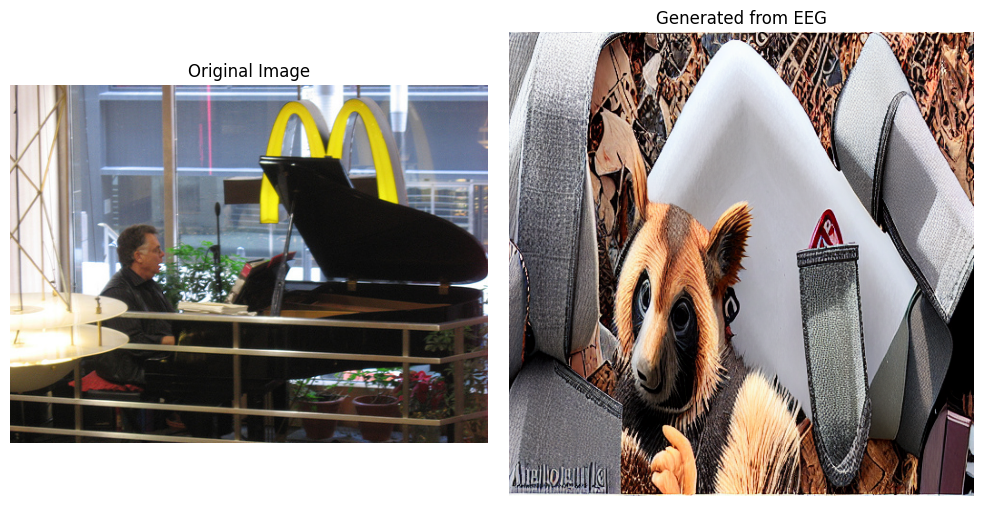

In [26]:
import torch
import numpy as np
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from diffusers.models.attention_processor import Attention
from torchvision.utils import save_image
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn


# -----------------------------------------
# Load your trained EEG → CLIP text model
# -----------------------------------------
class EEGToCLIPText(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(512, 77 * 768)

    def forward(self, x):
        out = self.linear(x)
        return out.view(-1, 77, 768)

eeg_to_clip_text = EEGToCLIPText().cuda()
checkpoint = torch.load("/kaggle/input/checkpoints/latest.pth", map_location="cuda")
eeg_to_clip_text.load_state_dict(checkpoint["model"])
eeg_to_clip_text.eval()
print("✅ Loaded eeg_to_clip_text from latest.pth")

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------------------
# Load VAE and UNet for inference
# -----------------------------------------
# class EEGCrossAttentionProcessor:
#     def __init__(self):
#         self.to_k = None
#         self.to_v = None

#     def __call__(self, query, encoder_hidden_states, **kwargs):
#         if self.to_k is None:
#             self.to_k = kwargs['attention'].to_k
#             self.to_v = kwargs['attention'].to_v
#         key = self.to_k(encoder_hidden_states)
#         value = self.to_v(encoder_hidden_states)
#         return kwargs['attention']._attention(query, key, value, **kwargs)



import torch
import torch.nn.functional as F
from diffusers.models.attention_processor import AttnProcessor

# class EEGCrossAttentionProcessor:
#     def __init__(self, fallback_processor=None):
#         from diffusers.models.attention_processor import AttnProcessor
#         self.fallback_processor = fallback_processor or AttnProcessor()

#     def __call__(self, attn_module, hidden_states, encoder_hidden_states=None, attention_mask=None, **kwargs):
#         # Use fallback for self-attention (no EEG context)
#         if encoder_hidden_states is None:
#             return self.fallback_processor(attn_module, hidden_states, encoder_hidden_states, attention_mask, **kwargs)

#         # Projections
#         query = attn_module.to_q(hidden_states)
#         key = attn_module.to_k(encoder_hidden_states)
#         value = attn_module.to_v(encoder_hidden_states)

#         batch_size, seq_len, proj_dim = query.shape
#         num_heads = attn_module.heads
#         head_dim = proj_dim // num_heads
        
#         # Reshape with runtime check
#         def reshape_heads(x):
#             bsz, seqlen, dim = x.shape
#             assert dim % num_heads == 0, f"Head reshape error: {dim=}, {num_heads=}"
#             return x.view(bsz, seqlen, num_heads, dim // num_heads).transpose(1, 2)  # (B, H, T, D)
        
#         query = reshape_heads(query)
#         key = reshape_heads(key)
#         value = reshape_heads(value)


#         # Scaled dot-product attention
#         scale = head_dim ** -0.5
#         attn_scores = torch.matmul(query, key.transpose(-2, -1)) * scale  # (B, H, Tq, Tk)
#         attn_probs = attn_scores.softmax(dim=-1)
#         attn_output = torch.matmul(attn_probs, value)  # (B, H, Tq, D)

#         # Merge heads
#         attn_output = attn_output.transpose(1, 2).reshape(batch_size, seq_len, proj_dim)

#         # Output projection
#         hidden_states = attn_module.to_out[0](attn_output)
#         hidden_states = attn_module.to_out[1](hidden_states)
#         return hidden_states

# class EEGCrossAttentionProcessor:
#     def __init__(self):
#         self.to_k = None
#         self.to_v = None

#     def __call__(self, query, encoder_hidden_states, **kwargs):
#         if self.to_k is None:
#             self.to_k = kwargs['attention'].to_k
#             self.to_v = kwargs['attention'].to_v
#         key = self.to_k(encoder_hidden_states)
#         value = self.to_v(encoder_hidden_states)
#         return kwargs['attention']._attention(query, key, value, **kwargs)

from diffusers.models.attention_processor import AttnProcessor

class EEGCrossAttentionProcessor:
    def __init__(self):
        self.fallback = AttnProcessor()

    def __call__(
        self,
        attn_module,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        **kwargs
    ):
        # If no cross-attention is happening (self-attention), use default
        if encoder_hidden_states is None:
            return self.fallback(
                attn_module,
                hidden_states,
                encoder_hidden_states,
                attention_mask,
                **kwargs
            )

        # Compute Q, K, V
        query = attn_module.to_q(hidden_states)
        key = attn_module.to_k(encoder_hidden_states)
        value = attn_module.to_v(encoder_hidden_states)

        # Shape: (B, SeqLen, D) -> (B, H, SeqLen, D_head)
        def reshape_heads(x):
            B, L, D = x.shape
            H = attn_module.heads
            D_head = D // H
            return x.view(B, L, H, D_head).transpose(1, 2)  # (B, H, L, D_head)

        query = reshape_heads(query)
        key = reshape_heads(key)
        value = reshape_heads(value)

        # Scaled dot-product attention
        scale = query.shape[-1] ** -0.5
        attn_scores = torch.matmul(query, key.transpose(-2, -1)) * scale  # (B, H, L_q, L_k)

        if attention_mask is not None:
            attn_scores = attn_scores + attention_mask

        attn_probs = attn_scores.softmax(dim=-1)
        attn_output = torch.matmul(attn_probs, value)  # (B, H, L_q, D_head)

        # Merge heads
        attn_output = attn_output.transpose(1, 2).reshape(hidden_states.shape)

        # Final projection
        hidden_states = attn_module.to_out[0](attn_output)
        hidden_states = attn_module.to_out[1](hidden_states)
        return hidden_states



class EEGConditionedUNet(UNet2DConditionModel):
    def set_attention_processor(self):
        for name, module in self.named_modules():
            if isinstance(module, Attention):
                processor = EEGCrossAttentionProcessor()
                module.set_processor(processor)

vae = AutoencoderKL.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="vae").eval().to(device)
unet = EEGConditionedUNet.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="unet").to(device)
checkpoint = torch.load("/kaggle/input/checkpoints/latest.pth", map_location=device)
unet.load_state_dict(checkpoint["unet"])
unet.eval()
print("✅ Loaded fine-tuned UNet from latest.pth")

from diffusers.models.attention_processor import AttnProcessor

# Replace all attention processors
eeg_processor = EEGCrossAttentionProcessor()
unet.set_attn_processor(eeg_processor)
# -----------------------------------------
# EEG preprocessing utilities
# -----------------------------------------
# def normalize_channels(epoch, means=None, stddevs=None):
#     if not isinstance(epoch, torch.Tensor):
#         epoch = torch.tensor(epoch.copy(), dtype=torch.float32)
#     if means is None or stddevs is None:
#         means = epoch.mean(dim=1, keepdim=True)
#         stddevs = epoch.std(dim=1, keepdim=True)
#     else:
#         means = torch.tensor(means, dtype=epoch.dtype)
#         stddevs = torch.tensor(stddevs, dtype=epoch.dtype)
#     stddevs = stddevs.clone()
#     stddevs[stddevs == 0] = 1e-6
#     return (epoch - means) / stddevs

# def pad_channels_to_128(epoch):
#     num_channels = epoch.shape[0]
#     if num_channels == 128:
#         return epoch
#     elif num_channels < 128:
#         reps = 128 // num_channels + 1
#         padded = np.tile(epoch, (reps, 1))[:128, :]
#         return padded
#     else:
#         return epoch[:128, :]

# def tokenize_sample(eeg_sample, token_length=4):
#     C, T = eeg_sample.shape
#     pad_length = (token_length - (T % token_length)) % token_length
#     if pad_length > 0:
#         padded_data = np.pad(eeg_sample, ((0, 0), (0, pad_length)), mode='edge')
#     else:
#         padded_data = eeg_sample
#     num_tokens = padded_data.shape[1] // token_length
#     tokens = padded_data.reshape(128, num_tokens, token_length)
#     tokens = np.transpose(tokens, (1, 0, 2))  # (num_tokens, 128, 4)
#     return tokens

# -----------------------------------------
# Load pretrained projection layer
# -----------------------------------------

# projection = nn.Linear(128 * 4, 1024).to(device)


# def embed(tokens):
#     if isinstance(tokens, np.ndarray):
#         tokens = torch.from_numpy(tokens).to(torch.float32)
#     tokens = tokens.to(device)  # ✅ Move to device
#     flattened = tokens.reshape(-1, 128 * 4)
#     embeddings = projection(flattened)
#     return embeddings


# -----------------------------------------
# Load pretrained EEG→CLIP projector
# -----------------------------------------

# model = EEGToCLIPProjector().to(device)
# model.load_state_dict(torch.load("/kaggle/input/clipprojector/eeg_to_clip_projector_best (1).pth"))
# model.eval()
# print("✅ Loaded EEG → CLIP projector")

# -----------------------------------------
# Generation function
# -----------------------------------------
def generate_image_from_eeg(eeg_embed_avg):
    # if isinstance(eeg_embed_avg, np.ndarray):
    #     eeg_embed_avg_tensor = torch.tensor(eeg_embed_avg, dtype=torch.float32).to(device)
    # else:
    #     eeg_embed_avg_tensor = eeg_embed_avg.to(torch.float32).to(device)

    # with torch.no_grad():
    #     projected_clip = model(eeg_embed_avg_tensor.unsqueeze(0))  # EEG → CLIP
    #     cond_embedding = eeg_to_clip_text(projected_clip).to(device)

    cond_embedding = eeg_to_clip_text(eeg_embed_avg.to(device)) # shape: [1, 77, 768]
    inference_scheduler = DDIMScheduler.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", subfolder="scheduler")
    inference_scheduler.set_timesteps(100)

    # CFG setup
    uncond_embedding = torch.zeros_like(cond_embedding)
    cond_embedding = torch.cat([uncond_embedding, cond_embedding])  # [2, 77, 768]
    
    # Sampling loop
    latent = torch.randn(1, 4, 64, 64).to(device)
    
    for t in tqdm(inference_scheduler.timesteps, desc="Sampling"):
        latent_input = inference_scheduler.scale_model_input(latent, t)
    
        with torch.no_grad():
            noise_pred = unet(
                latent_input.expand(2, -1, -1, -1),  # [2, 4, 64, 64]
                t,
                encoder_hidden_states=cond_embedding
            ).sample
    
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)
        latent = inference_scheduler.step(noise_pred, t, latent).prev_sample

    with torch.no_grad():
        image = vae.decode(latent / 0.18215).sample

    image = (image.clamp(-1, 1) + 1) / 2
    return image.cpu()


# -----------------------------------------
# Generate and Display Image
# -----------------------------------------
# -----------------------------------------
# Assume you already imported everything and loaded models
# -----------------------------------------

# -----------------------------------------
# EEG 1D Reshape Utility (NEW)
# -----------------------------------------
# def reshape_1d_eeg(eeg_1d, num_channels=128):
#     eeg_1d = np.array(eeg_1d)
#     total_points = eeg_1d.shape[0]
#     pad_len = (num_channels - (total_points % num_channels)) % num_channels
#     if pad_len > 0:
#         eeg_1d = np.pad(eeg_1d, (0, pad_len), mode='edge')
#     reshaped = eeg_1d.reshape(num_channels, -1)
#     return reshaped

# -----------------------------------------
# Use a sample EEG and image
# -----------------------------------------
sample_idx = 1

# ✅ Load EEG (1D array)
raw_1d = projected_embeddings[sample_idx] # Your 1D EEG array
# sample_eeg = reshape_1d_eeg(raw_1d)  # → Shape: (128, time)
sample_eeg=raw_1d
# ✅ Load corresponding image
image_path = "/kaggle/input/eeg-code1/imageNet_images/n03452741/n03452741_16744.JPEG"
orig_img_pil = Image.open(image_path).convert("RGB")

# ✅ Generate image from EEG
image_tensor = generate_image_from_eeg(sample_eeg)
gen_img_pil = TF.to_pil_image(image_tensor.squeeze())

# ✅ Save and display
save_image(image_tensor, "/kaggle/working/generated_image.png")

# ✅ Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(orig_img_pil)
axs[0].axis("off")
axs[0].set_title("Original Image")

axs[1].imshow(gen_img_pil)
axs[1].axis("off")
axs[1].set_title("Generated from EEG")

plt.tight_layout()
plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# norms = [torch.norm(vec).item() for vec in projected_embeddings]
# sns.histplot(norms); plt.title("Norms of Projected EEG->CLIP Embeddings")

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # N EEG vectors and N matching image CLIP embeddings
# clip_target=torch.load("/kaggle/input/clipimage/clip_image_embeddings.pt", map_location="cuda")
# sim = torch.nn.functional.cosine_similarity(projected_embeddings[0].to(device), clip_target['embeddings'].to(device), dim=1)
# print("Mean Cosine Similarity:", sim.mean().item())

# sns.heatmap(sim.unsqueeze(0).cpu().numpy(), cmap="viridis", cbar=True)
# plt.title("Cosine Similarity Between EEG→CLIP and Image CLIP Embeddings")
# plt.show()